# BayesOPT Example for showing Gittins >> EI
Extension of the numerical examples presented in Theorem 1 of Raul and Peter's paper which aimed to show the limitation of EIPC and EI. This experiment extends the scope from Pandora's box (discrete finite points) to Bayesian optimization (continuous domain) and shows Gittins outperforms EI.

In [1]:
import torch
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

## Define the amplitude function and the cost function 
The continuous amplitude function and the continuous cost function are constructed based on the variances and costs of the discrete finite points provided in the original example

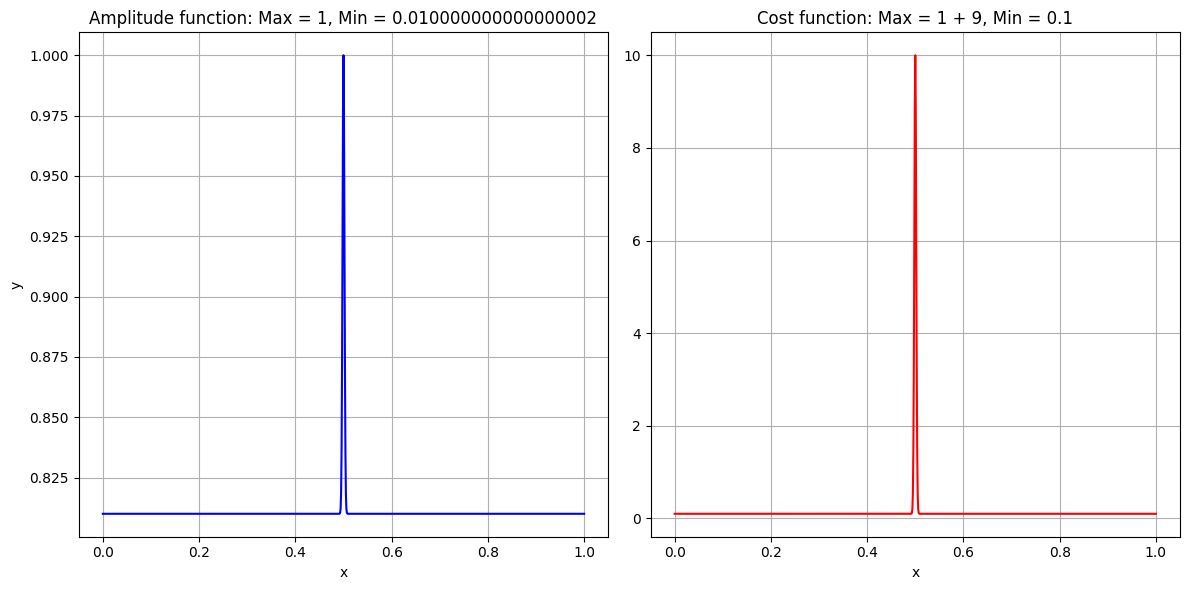

In [2]:
import matplotlib.pyplot as plt
# Define typical small values for epsilon and delta
cost_function_epsilon = 0.1
cost_function_delta = 9
amplitude_function_width = 0.002
cost_function_width = 0.002

# Define the functions for the amplitude and the cost
def squared_euclidean_distance(x, center):
    # Calculate the squared Euclidean distance
    return torch.sum((x - center) ** 2, dim=-1)

def amplitude_function(x):
    center = torch.full_like(x, 0.5)  # Center at [0.5, 0.5, ...]
    dist_squared = squared_euclidean_distance(x, center)
    amplitude = torch.exp(-dist_squared / (2 * amplitude_function_width**2)) * (1 - (1-cost_function_epsilon)**2) + (1-cost_function_epsilon)**2
    return amplitude

def cost_function(x):
    center = torch.full_like(x, 0.5)  # Center at [0.5, 0.5, ...]
    width = cost_function_width
    peak_height = 1 + cost_function_delta - cost_function_epsilon
    dist_squared = squared_euclidean_distance(x, center)
    cost = torch.exp(-dist_squared / (2 * width**2)) * peak_height + cost_function_epsilon
    return cost

# Generate x values from 0 to 1
x_values = torch.linspace(0, 1, 1001)

# Generate y values for amplitude function and cost function
y_values_amplitude = [amplitude_function(x).cpu().numpy() for x in x_values]
y_values_cost = [cost_function(x).cpu().numpy() for x in x_values]

# Plotting the functions
plt.figure(figsize=(12, 6))

# Plot for amplitude function
plt.subplot(1, 2, 1)
plt.plot(x_values, y_values_amplitude, label="Amplitude function", color='blue')
plt.title(f"Amplitude function: Max = 1, Min = {cost_function_epsilon**2}")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

# Plot for cost function
plt.subplot(1, 2, 2)
plt.plot(x_values, y_values_cost, label="Cost function", color='red')
plt.title(f"Cost function: Max = 1 + {cost_function_delta}, Min = {cost_function_epsilon}")
plt.xlabel("x")
plt.grid(True)

plt.tight_layout()
plt.show()

## Define the objective function
The objective functions are constructed as sample paths drawn from the Matern kernel multiplied by the amplitude function

In [3]:
from pandora_bayesopt.utils import create_objective_function
# Create the objective model
dim = 1
nu = 2.5
lengthscale = 0.01
outputscale = 1.0
num_rff_features = 1280
seed = 0
torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

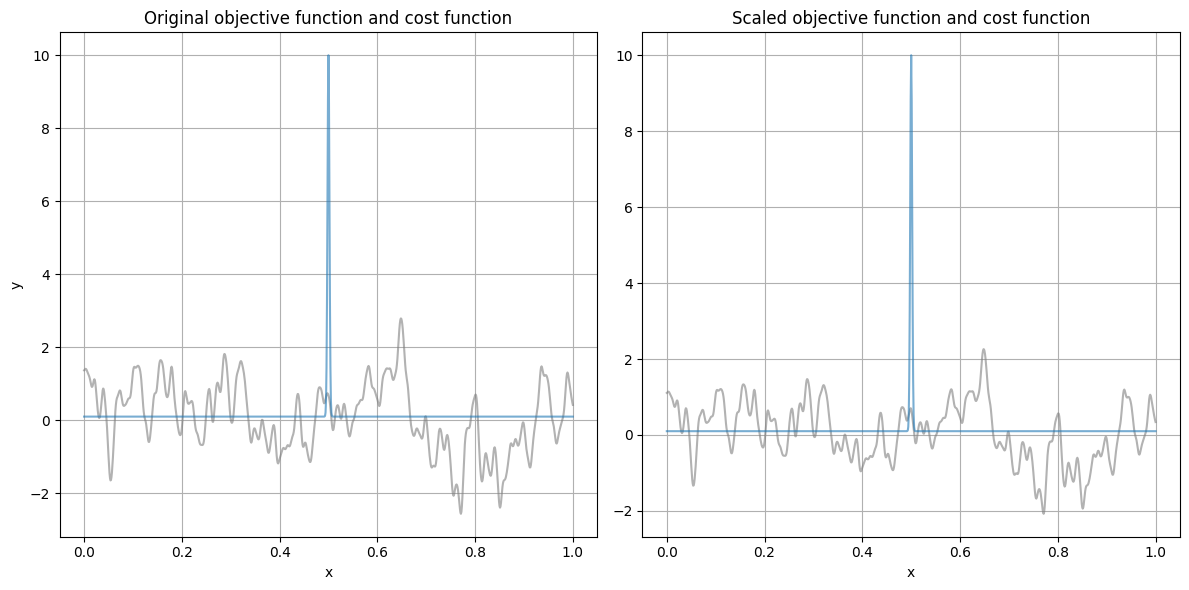

In [4]:
test_x = torch.linspace(0, 1, 1001)

# Plotting the functions
plt.figure(figsize=(12, 6))

# Plot for original objective function
plt.subplot(1, 2, 1)
plt.plot(test_x.cpu().numpy(), matern_sample(test_x.view(-1,1)).cpu().numpy(), color='tab:grey', label="Original objective function", alpha=0.6)
plt.plot(test_x.cpu().numpy(), cost_function(test_x.view(-1,1)).cpu().numpy(), label="Cost function", alpha=0.6)
plt.title(f"Original objective function and cost function")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

# Plot for scaled objective function
plt.subplot(1, 2, 2)
plt.plot(test_x.cpu().numpy(), objective_function(test_x.view(-1,1)).cpu().numpy(), color='tab:grey', label="Scaled objective function", alpha=0.6)
plt.plot(test_x.cpu().numpy(), cost_function(test_x.view(-1,1)).cpu().numpy(), label="Cost function", alpha=0.6)
plt.title(f"Scaled objective function and cost function")
plt.xlabel("x")
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
def plot_posterior(ax,objective_function,model,test_x,train_x,train_y):
    
    with torch.no_grad():
        
        # Plot the objective function at the test points
        ax.plot(test_x.cpu().numpy(), objective_function(test_x.view(-1,1)).numpy(), 'tab:grey', alpha=0.6)
    
        # Calculate the posterior at the test points
        posterior = model.posterior(test_x.unsqueeze(1).unsqueeze(1))

        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        lower = lower.squeeze(-1).squeeze(-1)
        upper = upper.squeeze(-1).squeeze(-1)
        # Plot training points as black stars
        ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*', alpha=0.8)
        # Plot posterior means as blue line
        ax.plot(test_x.cpu().numpy(), posterior.mean.squeeze(-1).squeeze(-1).cpu().numpy(), alpha=0.8)
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.2)
        
    
    ax.legend(['Objective Function', 'Observed Data', 'Mean', 'Confidence'])

### Define a customized kernel as Matern kernel with input-dependent amplitude (outputscale)

In [6]:
from gpytorch.kernels import MaternKernel
from pandora_bayesopt.kernel import VariableAmplitudeKernel

## Fit a GP model with observation data and a specified kernel

In [7]:
from pandora_bayesopt.utils import fit_gp_model

In [8]:
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = lengthscale
base_kernel.raw_lengthscale.requires_grad = False
kernel = VariableAmplitudeKernel(base_kernel, amplitude_function)

In [9]:
maximize = True
budget = 12

In [10]:
# Find the global optimum using grid search
grid_points = torch.linspace(0, 1, 1+int(10/lengthscale))
grid_values = objective_function(grid_points.view(-1,1))
global_optimum_value = torch.max(grid_values)
global_optimum_value

tensor(2.2597)

## Test EI policy

Iteration 0, measuring at x=0.500000009391067, y=0.6845480503582899


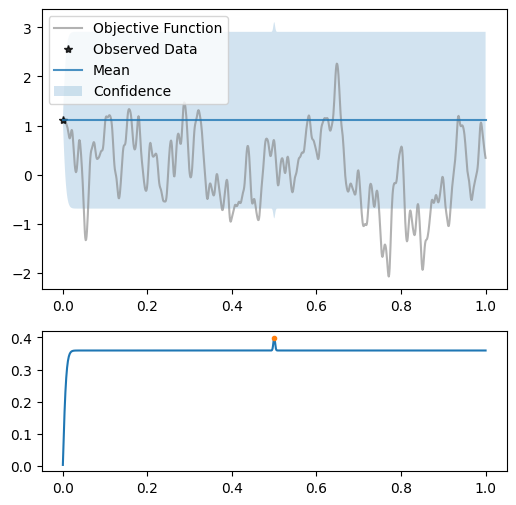

new cost: 9.999999999890862
cumulative cost: 9.999999999890862

Iteration 1, measuring at x=0.016641273865809443, y=0.7415127725963725


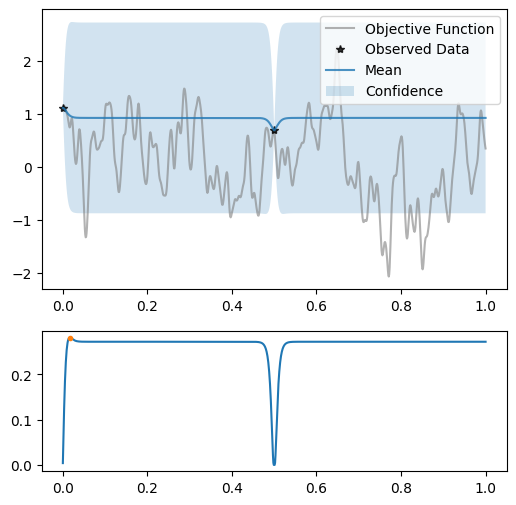

new cost: 0.1
cumulative cost: 10.099999999890862

Iteration 2, measuring at x=0.31110931280517723, y=0.8901925291957985


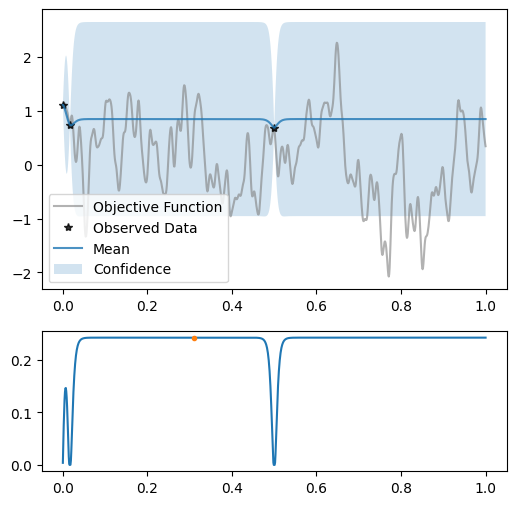

new cost: 0.1
cumulative cost: 10.199999999890862



In [11]:
import warnings

# Custom filter to suppress specific warnings
def custom_warning_filter(message, category, filename, lineno, file=None, line=None):
    if "Input data is not standardized" in str(message):
        return False
    return True

warnings.filterwarnings("ignore")
warnings.showwarning = custom_warning_filter

from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

grid_points = torch.linspace(0, 1, 1+int(10/lengthscale))
grid_values = objective_function(grid_points.view(-1,1))
global_optimum_point, global_optimum_value = torch.argmax(grid_values), torch.max(grid_values)

x = torch.zeros(dim).unsqueeze(0)
y = objective_function(x)
best_f = y.max().item() if maximize else y.min().item()

EI_best = [best_f] # This will store the best value
cumulative_cost = 0
EI_cumulative_cost_history = [0]

i = 0

while True:
    
    model = fit_gp_model(X=x, objective_X=y, kernel=kernel)
    
    # Optimize EI
    BoTorch_EI = ExpectedImprovement(model=model, best_f=best_f, maximize=maximize)
    new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=torch.stack([torch.zeros(dim), torch.ones(dim)]),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    if i < 3:

        print('Iteration {}, measuring at x={}, y={}'.format(i,new_point.item(), objective_function(new_point).item()) )
        
        # Plot the posterior and the EI
        f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
        
        # Plot the posterior
        plot_posterior(ax1,objective_function,model,test_x,x,y)
        
        # Plot EI
        acq = BoTorch_EI.forward(test_x.unsqueeze(1).unsqueeze(1))
        ax2.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EI.numpy(),'.')
        
        
        plt.show()
    
    # Add the new data
    x = torch.cat((x,new_point))
    new_value = objective_function(new_point)
    y = torch.cat((y, new_value))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EI_best.append(best_f)
    
    cumulative_cost += cost_function(new_point).item()
    if i < 3:
        print("new cost:", cost_function(new_point).item())
        print("cumulative cost:", cumulative_cost)
        print()
    EI_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

## Test Gittins policy with constant lambda 0.0001

Iteration 0, measuring at x=0.10453993641060431, y=1.1725838555940924


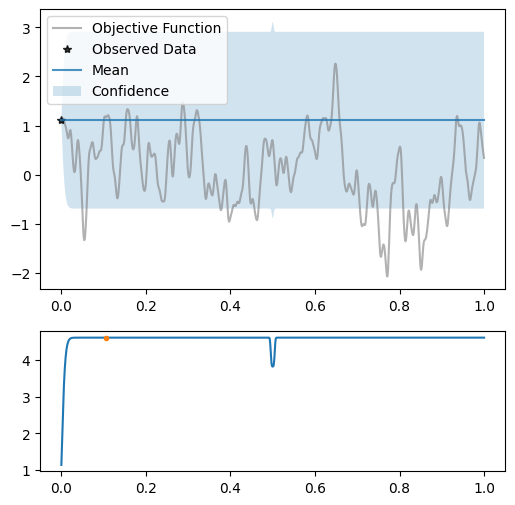

new cost: 0.1
cumulative cost: 0.1

Iteration 1, measuring at x=0.14119322410662308, y=0.3749392932650642


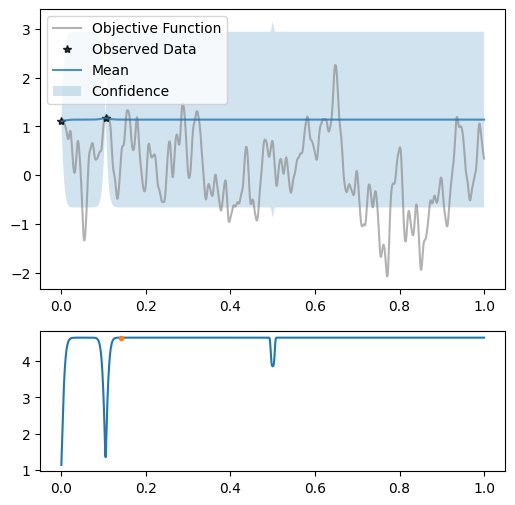

new cost: 0.1
cumulative cost: 0.2

Iteration 2, measuring at x=0.08081739701632637, y=0.32065740275409144


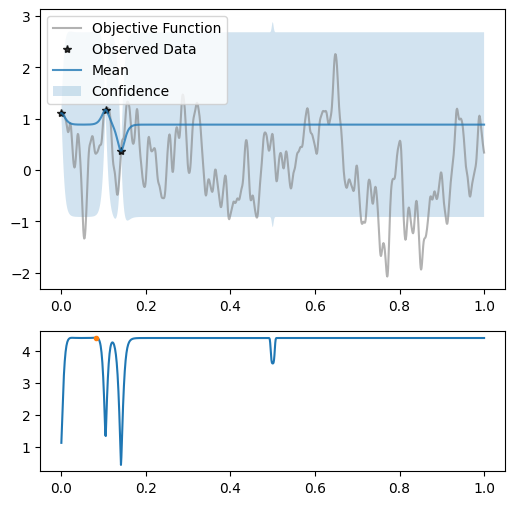

new cost: 0.1
cumulative cost: 0.30000000000000004



In [12]:
from pandora_bayesopt.acquisition.gittins import GittinsIndex

torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

grid_points = torch.linspace(0, 1, 1+int(10/lengthscale))
grid_values = objective_function(grid_points.view(-1,1))
global_optimum_point, global_optimum_value = torch.argmax(grid_values), torch.max(grid_values)

x = torch.zeros(dim).unsqueeze(0)
y = objective_function(x)
best_f = y.max().item() if maximize else y.min().item()

GIlmbda_best = [best_f] # This will store the best value
cumulative_cost = 0
GIlmbda_cumulative_cost_history = [0]

i = 0

while True:
    
    model = fit_gp_model(X=x, objective_X=y, kernel=kernel)
    
    # Optimize Gittins
    GIlmbda = GittinsIndex(model=model, lmbda=0.0001, maximize=maximize, cost=cost_function)
    new_point, new_point_GIlmbda = optimize_acqf(
        acq_function=GIlmbda,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    new_value = objective_function(new_point)

    if i < 3:

        print('Iteration {}, measuring at x={}, y={}'.format(i,new_point.item(), objective_function(new_point).item()) )

        # Plot the posterior and the Gittins
        f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
    
        # Plot the posterior
        plot_posterior(ax1, objective_function, model, test_x, x, y)
    
        # Plot Gittins
        GIlmbda_acq = GIlmbda.forward(test_x.unsqueeze(1).unsqueeze(1))
        ax2.plot(test_x.numpy(), GIlmbda_acq.detach().numpy(), '-', new_point.item(), new_point_GIlmbda.item(), '.')
        plt.show()


    # Add the new data
    x = torch.cat((x, new_point))
    y = torch.cat((y, new_value))

    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
    GIlmbda_best.append(best_f)
        
    cumulative_cost += cost_function(new_point).item()
    if i < 3:
        print("new cost:", cost_function(new_point).item())
        print("cumulative cost:", cumulative_cost)
        print()
    GIlmbda_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

## Plot best observed vs cumulative cost until the budget

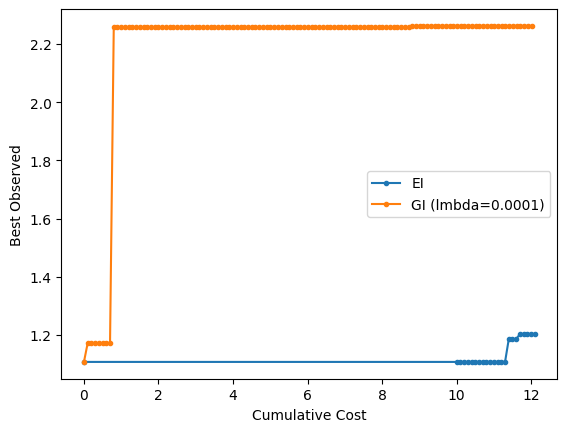

In [13]:
plt.plot(EI_cumulative_cost_history, EI_best, '.-', label="EI")
plt.plot(GIlmbda_cumulative_cost_history, GIlmbda_best, '.-', label="GI (lmbda=0.0001)")
plt.xlabel('Cumulative Cost')
plt.ylabel('Best Observed')
plt.legend()